In [3]:
# Re-import necessary libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image

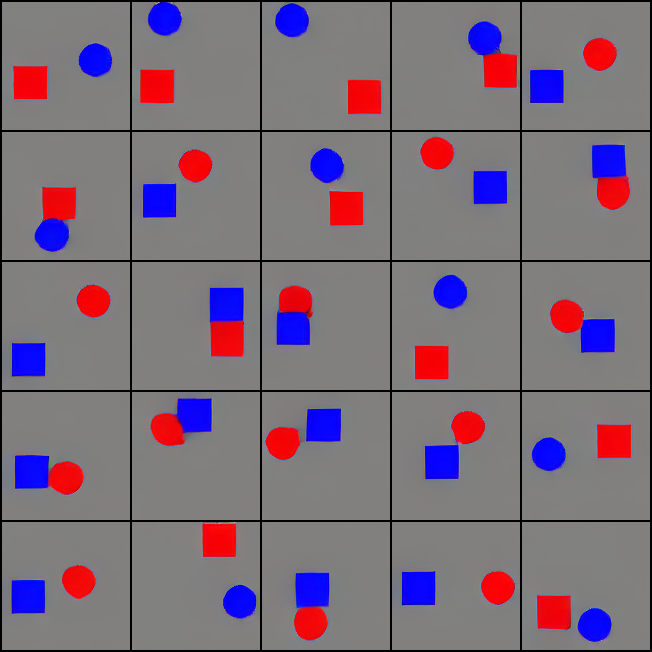

In [4]:
# Load the local image
prompt_names = [
    "blue_circle_is_above_and_to_the_right_of_blue_square",
    "blue_circle_is_above_blue_square",
    "blue_square_is_to_the_right_of_red_circle",
    "blue_triangle_is_above_red_triangle",
    "blue_triangle_is_to_the_upper_left_of_red_square",
    "circle_is_below_red_square",
    "red_circle_is_above_square",
    "red_circle_is_to_the_left_of_blue_square",
    "red_is_above_blue",
    "red_is_to_the_left_of_red",
    "triangle_is_above_and_to_the_right_of_square",
    "triangle_is_above_red_circle",
    "triangle_is_to_the_left_of_square",
    "triangle_is_to_the_left_of_triangle",
    "triangle_is_to_the_upper_left_of_square",
]

sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples"
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


def load_image(step_num, prompt_id, sample_root=sample_root):
    image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
    image = Image.open(image_path)
    return image


def load_image_grid(step_num, prompt_id, sample_root=sample_root):
    image = load_image(step_num, prompt_id, sample_root)
    return split_image_into_grid(image)


prompt_id = 2
step_num = 10000
image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
image = Image.open(image_path)
image

### Detect object and classify

In [56]:
def find_classify_objects(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    # go through each color channel
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
                expected_area = np.nan
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    classified_objects_df
    return classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)


12 triangle_is_to_the_left_of_square


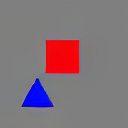

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (242, 6, 12)      (62, 57)  1067.5    1024.000000
1       1  Triangle   (6, 7, 244)    (36, 92.0)   428.0     443.405007


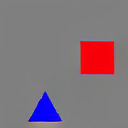

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       3    Square  (246, 3, 11)      (97, 58)  1038.0    1024.000000
1       1  Triangle  (12, 5, 244)   (45, 105.0)   464.5     443.405007


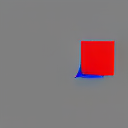

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (234, 7, 11)      (97, 58)  1028.5         1024.0


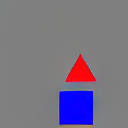

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       2  Triangle  (245, 11, 17)    (80, 67.0)   409.5     443.405007
1       1    Square    (8, 4, 251)     (76, 107)  1074.5    1024.000000


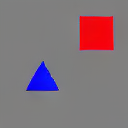

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square   (241, 7, 15)      (96, 33)  1071.5    1024.000000
1       1  Triangle  (16, 15, 242)    (42, 75.0)   460.0     443.405007


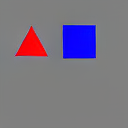

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (245, 6, 11)    (31, 40.0)   443.0     443.405007
1       1    Square  (11, 4, 249)      (79, 42)  1026.5    1024.000000


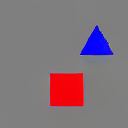

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (243, 5, 12)      (67, 90)  1056.5    1024.000000
1       1  Triangle  (11, 7, 245)    (96, 40.0)   477.5     443.405007


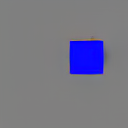

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 7, 251)      (86, 57)  1055.5         1024.0


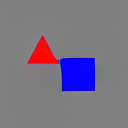

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (244, 10, 15)    (43, 49.0)   419.0     443.405007
1       3    Square   (10, 3, 248)      (77, 74)  1058.0    1024.000000


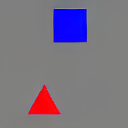

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (244, 10, 17)    (44, 98.0)   462.5     443.405007
1       1    Square    (9, 4, 249)      (70, 25)  1040.0    1024.000000


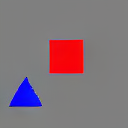

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square   (244, 8, 14)      (66, 56)  1095.5    1024.000000
1       1  Triangle  (16, 15, 243)    (25, 90.0)   483.0     443.405007


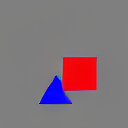

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square   (241, 6, 13)      (79, 74)  1069.0    1024.000000
1       1  Triangle  (13, 11, 242)    (55, 86.0)   441.5     443.405007


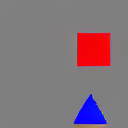

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       2    Square    (245, 3, 9)      (94, 49)  1010.5    1024.000000
1       1  Triangle  (15, 12, 246)   (90, 108.0)   508.5     443.405007


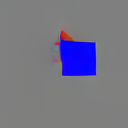

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 4, 248)      (77, 57)  1119.0         1024.0


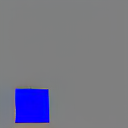

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (8, 5, 249)     (32, 105)  1067.5         1024.0


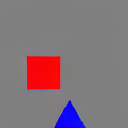

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (246, 8, 11)      (43, 73)  1048.5    1024.000000
1       1  Triangle  (16, 8, 245)   (69, 115.0)   405.5     443.405007


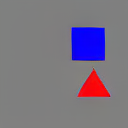

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (242, 10, 16)    (94, 83.0)   439.5     443.405007
1       1    Square   (12, 4, 247)      (88, 43)  1031.5    1024.000000


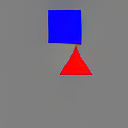

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (246, 7, 11)    (76, 62.0)   401.0     443.405007
1       1    Square  (11, 4, 248)      (65, 27)  1053.5    1024.000000


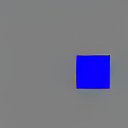

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 4, 248)      (93, 72)  1051.0         1024.0


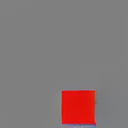

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (224, 20, 14)     (79, 107)  1046.0         1024.0


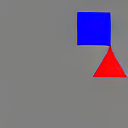

   Object     Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (247, 6, 9)   (110, 60.0)   451.0     443.405007
1       3    Square  (8, 3, 250)      (94, 28)  1045.0    1024.000000


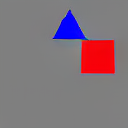

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (244, 7, 14)      (98, 57)  1047.5    1024.000000
1       2  Triangle   (8, 7, 247)    (69, 24.0)   470.5     443.405007


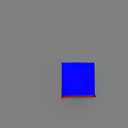

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 7, 248)      (78, 78)  1012.0         1024.0


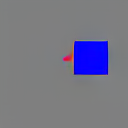

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (7, 3, 249)      (91, 58)  1068.5         1024.0


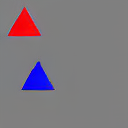

   Object     Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (243, 8, 14)    (25, 20.0)  458.5     443.405007
1       1  Triangle  (12, 9, 241)    (38, 75.0)  445.5     443.405007


In [58]:
# image = load_image(step_num, prompt_id)
# display(image)
step_num = 25000
prompt_id = 12
subimages = load_image_grid(step_num, prompt_id)
print(prompt_id, prompt_names[prompt_id])
for subimage in subimages:
    display(subimage)
    classified_objects_df = find_classify_objects(subimage)
    print(classified_objects_df)


In [30]:

subimages = load_image_grid(step_num, prompt_id)
# Reload the image
# image_path = "/mnt/data/35770291-C7B3-46DC-B609-516FE6349F33.png

image = np.array(subimages[0]) #cv2.imread(image_path)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
classified_objects = []
for channel in range(3):
    gray_image = image[:,:,channel]
    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours of the shapes
    contours, _ = cv2.findContours(binary_mask, 
                                cv2.RETR_EXTERNAL, 
                                cv2.CHAIN_APPROX_SIMPLE)

    # Initialize results
    for i, contour in enumerate(contours):
        # Calculate properties of the contour
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        # Shape classification based on the number of vertices
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Square" if abs(w - h) < 5 else "Rectangle"
        elif len(approx) > 4:
            shape = "Circle"
        else:
            shape = "Unknown"
        # Calculate the color of the shape by extracting the region
        mask = np.zeros_like(gray_image)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_color = cv2.mean(image, mask=mask)
        # Add to results
        classified_objects.append({
            "Object": i + 1,
            "Shape": shape,
            "Color (RGB)": tuple(map(int, mean_color[:3])),
            "Center (x, y)": (x + w // 2, y + h // 2),
            "Area": area
            
        })

# Convert to DataFrame for better visualization
classified_objects_df = pd.DataFrame(classified_objects)
classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)

,Object,Shape,Color (RGB),"Center (x, y)",Area
0,1,Square,"(246, 1, 8)","(28, 80)",1010.0
1,1,Circle,"(5, 5, 252)","(93, 58)",790.5


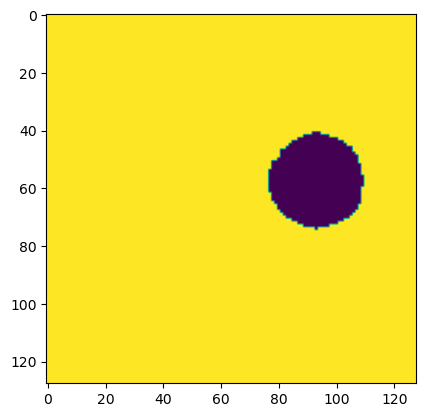

In [25]:
import matplotlib.pyplot as plt
plt.imshow(binary_mask)

,Object,Shape,Color (RGB),"Center (x, y)"
0,1,Square,"(129, 112, 126)","(64, 64)"
